## **Rede Neural - Classificação** <br> COC361 - Inteligência Computacional (2021.2)
### Alunos: <br> Henrique Chaves (DRE 119025571) <br> Pedro Boechat (DRE 119065050)
<hr>

### • Importação das bibliotecas

In [1]:
# Bibliotecas padrão
from os import (
    listdir,
    makedirs
)
import pickle

# Bibliotecas do Jupyter
from IPython.display import display

# Bibliotecas para manipulação dos dados
import numpy as np
import pandas as pd

# SKLearn
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Tensorflow/Keras
from tensorflow.keras.layers import (
    Dense,
    Dropout
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from scikeras.wrappers import KerasClassifier
from tensorflow.config import list_physical_devices

# Bibliotecas para plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Número de GPUs disponíveis para o Tensorflow/Keras
print("Número de GPUs disponíveis: ", len(list_physical_devices('GPU')))

Número de GPUs disponíveis:  1


### • Download do dataset ([Link](https://www.kaggle.com/mathchi/diabetes-data-set?select=diabetes.csv))

### • Carregamento do dataset

In [3]:
# Carregamento dos dados
df = pd.read_csv("./data/classification/diabetes.csv")

### • Estudo do dataset
```
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)
```

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
display(df.head())
display(df.tail())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


### • Análise Exploratória dos Dados

### • Limpeza dos dados

#### 1. Imputar dados faltantes

In [8]:
df.eq(0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [9]:
columns_to_impute = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

df[columns_to_impute] = df[columns_to_impute].applymap(lambda x: np.nan if x == 0 else x)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


In [10]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')


df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.0,165.0,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0
766,1.0,126.0,60.0,35.2,134.2,30.1,0.349,47.0,1


### • Salvar dataset limpo

In [11]:
df.to_csv("./data/classification/df_clean.csv", index=False)

### • Definindo `features` e  `targets`

In [12]:
features = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
            "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
            
targets = ["Outcome"]

In [13]:
df_X = df[features]

print("df_X shape:", df_X.shape)
df_X.sample(5)

df_X shape: (768, 8)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
692,2.0,121.0,70.0,32.0,95.0,39.1,0.886,23.0
312,2.0,155.0,74.0,17.0,96.0,26.6,0.433,27.0
767,1.0,93.0,70.0,31.0,66.6,30.4,0.315,23.0
104,2.0,85.0,65.0,33.8,106.6,39.6,0.930,27.0
503,7.0,94.0,64.0,25.0,79.0,33.3,0.738,41.0


In [14]:
df_y = df[targets]

print("df_y shape:", df_y.shape)
df_y.sample(5)

df_y shape: (768, 1)


,Outcome
328,1
181,0
432,0
16,1
651,0


### • Normalização dos dados

In [15]:
# Definição do scaler
scaler = StandardScaler

# Instância do scaler para X e Y
X_scaler = scaler()

In [16]:
X = X_scaler.fit_transform(df_X)
y = df_y.to_numpy()


print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (768, 8)
y shape: (768, 1)


### • Definição de callbacks da rede

In [17]:
# Reduz a learning rate caso o modelo esteja estagnado
lr_reduce = ReduceLROnPlateau(
    min_delta=1e-5,
    patience=5,
    verbose=1
)

# Lista contendo os checkpoints definidos
callbacks = [
    lr_reduce
]

### • Definição das camadas da rede

In [18]:
def create_model(
    n_hidden_layers,
    n_neurons,
    dropout_rate,
    dropout_last_layer,
    input_shape=(X.shape[1], )
):
    """Função que retorna o modelo compilado a partir dos parâmetros.
    Args:
        n_layers (int): Número de camadas da rede. 2 por padrão.
        n_neurons (int): Número de neurônios da rede. 32 por padrão.
        dropout_rate (float): Taxa de dropout. 0.2 por padrão.
        dropout_last_layer (bool): Se terá dropout na última camada.
        False por padrão.
        input_shape (Tuple[int, ]): Forma da entrada. [8] por padrão.
    """
    # Criação do modelo sequencial
    model = Sequential()

    # Número de variáveis de entrada
    model.add(
            Dense(
                n_neurons,
                activation='relu',
                input_shape=input_shape
            )
        )

    for i in range(n_hidden_layers):
        # Camada de adensamento com ativação RELU
        model.add(
            Dense(
                n_neurons,
                activation='relu'
            )
        )

        # Camada de dropout
        if dropout_rate > 0.0:
            if (i == n_hidden_layers - 1) and (not dropout_last_layer):
                continue
            model.add(
                Dropout(
                    dropout_rate
                )
            )

    # Camada de adensamento com ativação LINEAR
    model.add(Dense(1, activation='sigmoid'))

    # Compilação do modelo
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [19]:
# Criação do classificador com wrapper do SKLearn
classifier = KerasClassifier(
    model=create_model,
    n_hidden_layers=1,
    n_neurons=32,
    dropout_rate=0.0,
    dropout_last_layer=False,
    batch_size=32,
    epochs=100,
)

In [20]:
# Parâmetros para o Grid Search
param_grid = {
    "n_hidden_layers": [1, 2, 3],
    "n_neurons": [32, 64, 128],
    "dropout_rate": [0.0, 0.2],
    "dropout_last_layer": [False, True],
}

In [21]:
# Instância do Grid Search
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=1
)

In [22]:
# Treino do modelo
grid_result = grid_search.fit(
    X, y,
    callbacks=callbacks,
    verbose=0
)

3/3 [==============================] - 0s 991us/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


In [25]:
with open("./data/classification/classifier_grid_result.pkl", "wb") as f:
    pickle.dump(grid_result, f)

INFO:tensorflow:Assets written to: C:\Users\pedro\AppData\Local\Temp\tmpiinkedwb\assets


### • Avaliação da rede

NameError: name 'history' is not defined

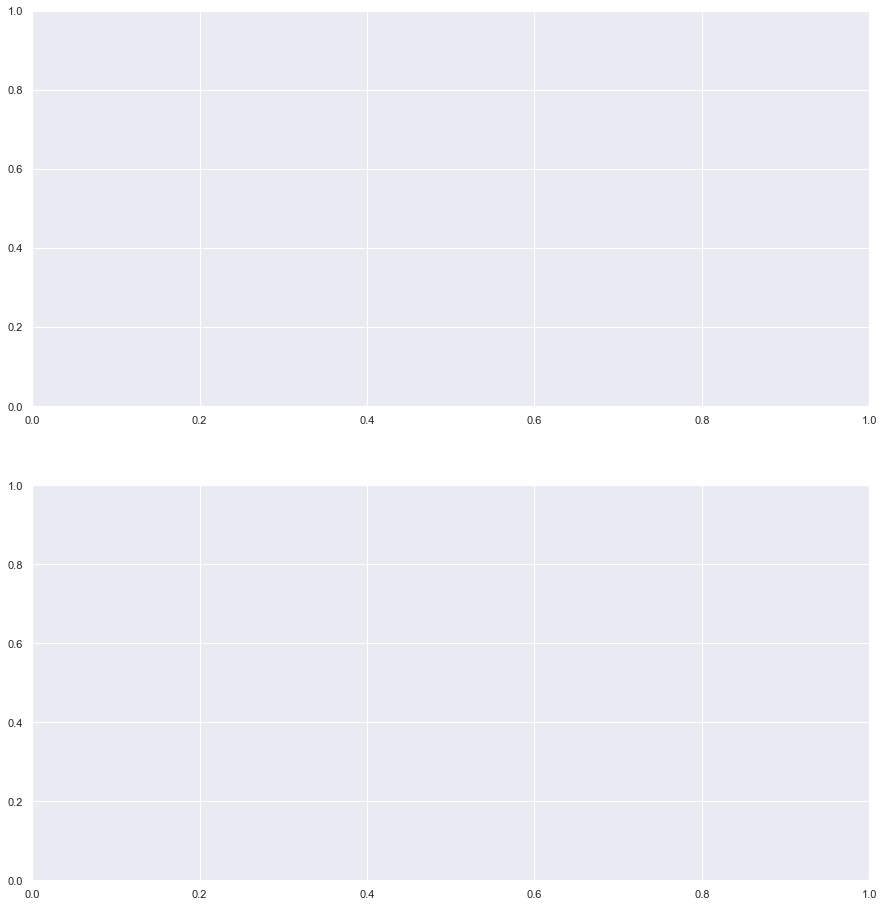

In [24]:
# Definição dos subplots
fig, ax = plt.subplots(figsize=(15, 16), nrows=2)

# Gráfico da acurácia do modelo por época
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Acurácia do modelo por época', fontsize=18)
ax[0].set_ylabel('Acurácia', fontsize=14)
ax[0].set_xlabel('Época', fontsize=14)
ax[0].legend(['Treino', 'Teste'], loc='upper left', fontsize=16)

# Gráfico da loss do modelo por época
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[0].set_title('Loss do modelo por época', fontsize=18)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].set_xlabel('Época', fontsize=14)
ax[0].legend(['Treino', 'Teste'], loc='upper left', fontsize=16)

# Ajuste do layout do plot
plt.tight_layout()

### • Predição usando a rede treinada

In [ ]:
y_test_pred = np.argmax(model.predict(X_test), axis=1)

### • Matriz de confusão

In [ ]:
# Criação da matriz de confusão
cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# Criação da visualização da matriz de confusão
cm_plt = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[0,1]
)

# Exibição da matriz de confusão
cm_plt.plot(cmap=plt.cm.Blues)
plt.show()